In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
from Bio import SeqIO
import glob
import copy
import sys
import pysam
import glob
import os
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [2]:
BLOOD_MICROBIOME_PATH = '/home/groups/dpwall/briannac/blood_microbiome/'
FIG_DIR=BLOOD_MICROBIOME_PATH + 'results/herpesvirus/'

colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src')
bam_mappings_file = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

virus_file = BLOOD_MICROBIOME_PATH + 'data/kraken_align/virus_filtered_species.df' 

## Load / format data

In [3]:
bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)
housekeeping_coverages = pd.read_table('/home/groups/dpwall/briannac/blood_microbiome/results/housekeeping_coverages.txt', sep=' ', header=None, index_col=0)
housekeeping_coverages.columns = ['EDAR', 'BGLOB']
housekeeping_coverages['EDAR'] = housekeeping_coverages['EDAR']/94750*150
housekeeping_coverages['BGLOB'] = housekeeping_coverages['BGLOB']/1734*150
housekeeping_coverages['mean'] = housekeeping_coverages.mean(axis=1)

# Normalized Read Counts

In [25]:
herpes_6a_contig = 'kraken:taxid|32603|NC_001664.4'
herpes_6b_contig = 'kraken:taxid|32604|NC_000898.1'
herpes_7_contig = 'kraken:taxid|10372|NC_001716.2'
decoy_contig = 'chrUn_JTFH01000690v1_decoy'
kraken_to_english_id ={'kraken:taxid|32603|NC_001664.4': 'Human betaherpesvirus 6A',
                      'kraken:taxid|32604|NC_000898.1': 'Human betaherpesvirus 6B',
                      'kraken:taxid|10372|NC_001716.2': 'Human betaherpesvirus 7',
                      'chrUn_JTFH01000690v1_decoy':'chrUn_JTFH01000690v1_decoy'}
coverages = np.load('/home/groups/dpwall/briannac/blood_microbiome/results/herpesvirus/coverages.npy', allow_pickle=True)
coverages_dict = coverages.item()
pairing_cols = list(set([tuple(p) for k in coverages_dict.keys() for p in coverages_dict[k].keys()]))
pairings_df = pd.DataFrame([[sum(coverages_dict[k][p][0].values()) if p in coverages_dict[k] else 0 for p in pairing_cols] for k in coverages_dict.keys()], columns=pairing_cols)
pairings_df.index = list(coverages_dict.keys())
pairings_df = pairings_df.loc[set(pairings_df.index).intersection(housekeeping_coverages.index)]
pairings_df[[c for c in pairings_df.columns if c[0]==c[1]]] = 2*pairings_df[[c for c in pairings_df.columns if c[0]==c[1]]]


df_herpesvirus_unnormed = pd.DataFrame()
df_herpesvirus_unnormed['Human betaherpesvirus 7'] = pairings_df[[c for c in pairings_df.columns if herpes_7_contig in c]].sum(axis=1)
df_herpesvirus_unnormed['Human betaherpesvirus 6A'] = pairings_df[[c for c in pairings_df.columns if herpes_6a_contig in c]].sum(axis=1)
df_herpesvirus_unnormed['Human betaherpesvirus 6B'] = pairings_df[[c for c in pairings_df.columns if herpes_6b_contig in c]].sum(axis=1)


pairings_df = pairings_df.apply(lambda x: np.array(x)/housekeeping_coverages.loc[pairings_df.index]['mean'].values, axis=0)
length_dict = {herpes_6a_contig:159378 , herpes_6b_contig:162114 , herpes_7_contig:153080}


df_herpesvirus = pd.DataFrame()
df_herpesvirus['Human betaherpesvirus 7'] = pairings_df[[c for c in pairings_df.columns if herpes_7_contig in c]].sum(axis=1)/length_dict[herpes_7_contig]
df_herpesvirus['Human betaherpesvirus 6A'] = pairings_df[[c for c in pairings_df.columns if herpes_6a_contig in c]].sum(axis=1)/length_dict[herpes_6a_contig]
df_herpesvirus['Human betaherpesvirus 6B'] = pairings_df[[c for c in pairings_df.columns if herpes_6b_contig in c]].sum(axis=1)/length_dict[herpes_6b_contig]

In [26]:
herpes_6a_contig = 'Human betaherpesvirus 6A'
herpes_6b_contig =  'Human betaherpesvirus 6B'
herpes_7_contig =  'Human betaherpesvirus 7'
decoy_contig = 'chrUn_JTFH01000690v1_decoy'

# Inheritance Patterns

In [27]:
def InheritanceLabels(thresh = .4, HHV  = 'Human betaherpesvirus 6B'):
    df_herpesvirus['relationship'] = bam_mappings.loc[df_herpesvirus.index].relationship
    df_herpesvirus['family'] = bam_mappings.loc[df_herpesvirus.index].family
    labels = ['low' for _ in df_herpesvirus.index]
    for n, i in enumerate(df_herpesvirus.index):
        if df_herpesvirus.loc[i][HHV] < thresh:
            continue
        fam = df_herpesvirus.loc[i].family
        df_fam = df_herpesvirus[(df_herpesvirus.family==fam)]
        if df_herpesvirus.loc[i].relationship=='sibling':
            if sum(df_fam[df_fam.relationship!='sibling'][HHV].values>thresh)>0:
                labels[n] = 'high HHV sample with high HHV parents/offspring'
            elif ('mother' not in df_fam.relationship.values) or ('father' not in df_fam.relationship.values):
                labels[n] = 'high HHV sample, not enough family members to confirm'
            else: labels[n] = 'high HHV child, low HHV parents'
        elif df_herpesvirus.loc[i].relationship!='sibling':
            if sum(df_fam[df_fam.relationship=='sibling'][HHV].values>thresh)>0:
                labels[n] = 'high HHV sample with high HHV parents/offspring'
            else:
                labels[n] = 'high HHV sample, not enough family members to confirm'
    return labels

In [28]:
df_6A = pd.DataFrame(df_herpesvirus[['Human betaherpesvirus 6A']])
df_6A.columns = ['read counts']
df_6A['status'] = df_6A['read counts']>.25
df_6A['labels'] = InheritanceLabels(.25, 'Human betaherpesvirus 6A')
df_6A['HHV'] = ['6A_' + str(i) for i in bam_mappings.loc[df_herpesvirus.index].bio_seq_source.values]


df_6B = pd.DataFrame(df_herpesvirus[['Human betaherpesvirus 6B']])
df_6B.columns = ['read counts']
df_6B['status'] = df_6B['read counts']>.25
df_6B['labels'] = InheritanceLabels(.25, 'Human betaherpesvirus 6B')
df_6B['HHV'] = ['6B_' + str(i) for i in bam_mappings.loc[df_herpesvirus.index].bio_seq_source.values]


df_7 = pd.DataFrame(df_herpesvirus[['Human betaherpesvirus 7']])
df_7.columns = ['read counts']
df_7['status'] = df_7['read counts']>.25
df_7['labels'] = InheritanceLabels(.25, 'Human betaherpesvirus 7')
df_7['HHV'] = ['7_' + str(i) for i in bam_mappings.loc[df_herpesvirus.index].bio_seq_source.values]
df_HHV =  pd.concat([df_6A, df_6B, df_7])
#df_HHV['read counts'] = np.log10(df_HHV['read_counts'] + 1)
df_HHV = df_HHV[['nan' not in i for i in df_HHV['HHV'].values]]


In [29]:
fams = df_HHV[(df_HHV.labels=='high HHV sample with high HHV parents/offspring') & ((df_HHV.HHV=='6B_LCL') | (df_HHV.HHV=='6B_WB'))].index
Counter(bam_mappings.loc[fams].family)

Counter({'AU3761': 2,
         'AU1589': 3,
         'AU0412': 3,
         'AU4056': 2,
         'AU2140': 2,
         'AU0800': 2})

In [30]:
df_HHV[df_HHV.HHV=='6A_LCL'].sort_values('read counts')[::-1][:20]

,read counts,status,labels,HHV
03C16632,0.476900,True,high HHV sample with high HHV parents/offspring,6A_LCL
06C54349,0.459923,True,high HHV sample with high HHV parents/offspring,6A_LCL
03C16633,0.454608,True,high HHV sample with high HHV parents/offspring,6A_LCL
03C16623,0.446290,True,high HHV sample with high HHV parents/offspring,6A_LCL
03C16621,0.445559,True,high HHV sample with high HHV parents/offspring,6A_LCL
03C16634,0.443103,True,high HHV sample with high HHV parents/offspring,6A_LCL
06C53148,0.442261,True,high HHV sample with high HHV parents/offspring,6A_LCL
06C53149,0.441582,True,high HHV sample with high HHV parents/offspring,6A_LCL
06C53151,0.439935,True,high HHV sample with high HHV parents/offspring,6A_LCL
02C11465,0.439605,True,"high HHV sample, not enough family members to ...",6A_LCL


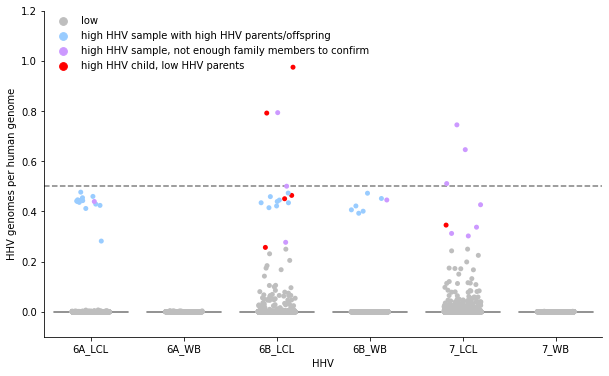

In [31]:
f, ax = plt.subplots(figsize=(10,6))
sns.set_palette(['#BEBEBE', '#99CCFF', '#CC99FF', '#FF0000'])
sns.stripplot(data =df_HHV, x='HHV', y='read counts', hue='labels', jitter=.2)
sns.boxplot(data =df_HHV, x='HHV', y='read counts', color='#ECECEC', showfliers=False)

#plt.yscale('symlog', linthresh=1)
plt.ylim(-.1,1.2)
plt.hlines(y=.5, xmin=-.5, xmax=5.5, color='grey', linestyle='dashed')
ax.legend(loc='center left', bbox_to_anchor=(0, .9), frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('HHV genomes per human genome')
plt.savefig(FIG_DIR + 'iciHHV_read_counts.svg')
plt.show()

# HHV count is driven by children



/home/users/briannac/.local/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/users/briannac/.local/lib/python3.6/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


MannwhitneyuResult(statistic=0.0, pvalue=0.0)

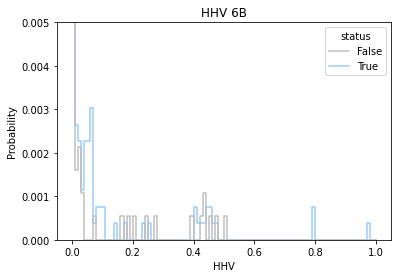

In [32]:
df_association = df_herpesvirus[
    df_herpesvirus['Human betaherpesvirus 6B']>=df_herpesvirus['Human betaherpesvirus 6A']][['Human betaherpesvirus 6B']].copy()
df_association.columns = ['HHV']
#df_association['HHV'] = np.log10(df_association.HHV+.01)
df_association['status'] = bam_mappings.loc[df_association.index].relationship
df_association['status'] = [str(s)=='sibling' for s in df_association['status']]
sns.histplot(data=df_association, bins=20,
             x='HHV', hue='status', common_norm=False, stat='probability', element='step', fill=False, binrange=(0,1), binwidth=.01)
#plt.yscale('log')
plt.ylim(0,.005)
plt.title('HHV 6B')
mannwhitneyu(df_association[df_association.status=='sibling'].HHV, df_association[df_association.status!='sibling'].HHV)

/home/users/briannac/.local/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/users/briannac/.local/lib/python3.6/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


MannwhitneyuResult(statistic=0.0, pvalue=0.0)

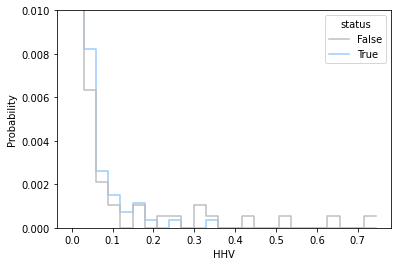

In [33]:
df_association = df_herpesvirus[['Human betaherpesvirus 7']].copy()
df_association.columns = ['HHV']
#df_association['HHV'] = np.log10(df_association.HHV+.01)
df_association['status'] = bam_mappings.loc[df_association.index].relationship
df_association['status'] = [str(s)=='sibling' for s in df_association['status']]
#df_association = df_association[bam_mappings.loc[df_association.index].relationship!='sibling']
#sns.histplot(data=df_association[(df_association.status=='autism') | (df_association.status=='nan')] ,
#             x='HHV', hue='status', stat='probability')
#df_association = df_association[bam_mappings.loc[df_association.index].bio_seq_source=='LCL']
sns.histplot(data=df_association, bins=25,
             x='HHV', hue='status', common_norm=False, stat='probability', element='step', fill=False)
plt.ylim(0,.01)
#plt.xlabel('log10(HHV count)')
#plt.yscale('log')
mannwhitneyu(df_association[df_association.status=='sibling'].HHV, df_association[df_association.status!='sibling'].HHV)

In [34]:
print(np.mean(df_6A.labels=='high HHV sample with high HHV parents/offspring'))
print(np.mean(df_6B.labels=='high HHV sample with high HHV parents/offspring'))

print(np.sum(df_6B.labels=='high HHV sample with high HHV parents/offspring'))

print(np.mean((df_6A.labels=='high HHV sample with high HHV parents/offspring') &
             (df_6B.labels=='high HHV sample with high HHV parents/offspring')))

0.003065469673746442
0.003065469673746442
14
0.0


In [35]:
h6a_high = df_herpesvirus[df_herpesvirus['Human betaherpesvirus 6A']>=1e4].index
h6a_med = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6A']>=1e3) & (df_herpesvirus['Human betaherpesvirus 6A']<1e4)].index
h6a_low = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6A']>=1e1) & (df_herpesvirus['Human betaherpesvirus 6A']<1e3)].index

h6b_high = df_herpesvirus[df_herpesvirus['Human betaherpesvirus 6B']>=1e4].index
h6b_med = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6B']>=1e3) & (df_herpesvirus['Human betaherpesvirus 6B']<1e4)].index
h6b_low = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6B']>=1e1) & (df_herpesvirus['Human betaherpesvirus 6B']<1e3)].index

h7_high = df_herpesvirus[df_herpesvirus['Human betaherpesvirus 7']>=1e4].index
h7_med = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 7']>=1e3) & (df_herpesvirus['Human betaherpesvirus 7']<1e4)].index
h7_low = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 7']>=1e1) & (df_herpesvirus['Human betaherpesvirus 7']<1e3)].index

# Genome-wide Coverages

In [36]:
herpes_6a_contig = 'kraken:taxid|32603|NC_001664.4'
herpes_6b_contig = 'kraken:taxid|32604|NC_000898.1'
herpes_7_contig = 'kraken:taxid|10372|NC_001716.2'
decoy_contig = 'chrUn_JTFH01000690v1_decoy'
kraken_to_english_id ={'kraken:taxid|32603|NC_001664.4': 'Human betaherpesvirus 6A',
                      'kraken:taxid|32604|NC_000898.1': 'Human betaherpesvirus 6B',
                      'kraken:taxid|10372|NC_001716.2': 'Human betaherpesvirus 7',
                      'chrUn_JTFH01000690v1_decoy':'chrUn_JTFH01000690v1_decoy'}

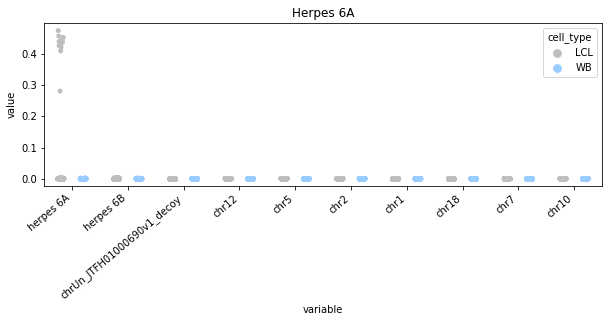

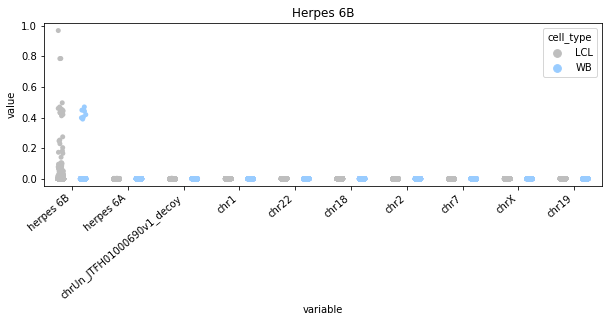

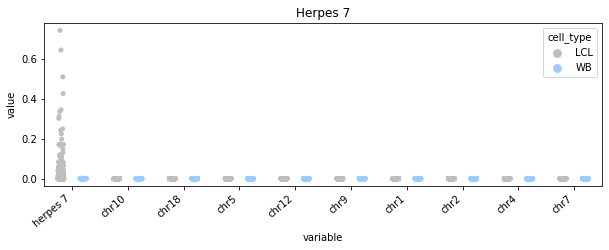

In [37]:
for contig in [herpes_6a_contig, herpes_6b_contig, herpes_7_contig]:
    pairings_df_contig = pairings_df[pairings_df.columns[[(c[1]==contig) | (c[0]==contig) for c in pairings_df.columns]]].copy()/length_dict[contig]
    #pairings_df_contig = np.log10(pairings_df_contig[np.log10(pairings_df_contig.max(axis=1))<100]+1)
    pairings_df_contig = pairings_df_contig[pairings_df_contig.sum().sort_values(ascending=False)[:10].keys()]
    pairings_df_contig.columns = [c[0] if c[1]==contig else c[1] for c in pairings_df_contig.columns]
    pairings_df_contig['cell_type'] = bam_mappings.loc[pairings_df_contig.index].bio_seq_source
    pairings_melt = pairings_df_contig.melt(id_vars=['cell_type'])
    pairings_melt = pairings_melt.replace(herpes_6a_contig, 'herpes 6A').replace(herpes_6b_contig, 'herpes 6B').replace(herpes_7_contig, 'herpes 7')
    plt.figure(figsize=(10,3))
    ax = sns.stripplot(data=pairings_melt,x='variable', y='value', hue='cell_type', dodge=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha='right')
    #plt.yscale('log')
    if contig==herpes_6a_contig: plt.title('Herpes 6A')
    if contig==herpes_6b_contig: plt.title('Herpes 6B')
    if contig==herpes_7_contig: plt.title('Herpes 7')
    plt.show()

In [38]:
# Labels
high_6a = df_herpesvirus[df_herpesvirus['Human betaherpesvirus 6A']>.25].index
high_6b = df_herpesvirus[df_herpesvirus['Human betaherpesvirus 6B']>.25].index
med_6b = list(set(df_herpesvirus[df_herpesvirus['Human betaherpesvirus 6B']>.1].index).difference(high_6b).difference(high_6a))
high_7 = df_herpesvirus[df_herpesvirus['Human betaherpesvirus 7']>.25].index
med_7 = list(set(df_herpesvirus[df_herpesvirus['Human betaherpesvirus 7']>.1].index).difference(high_7))


# Pairings

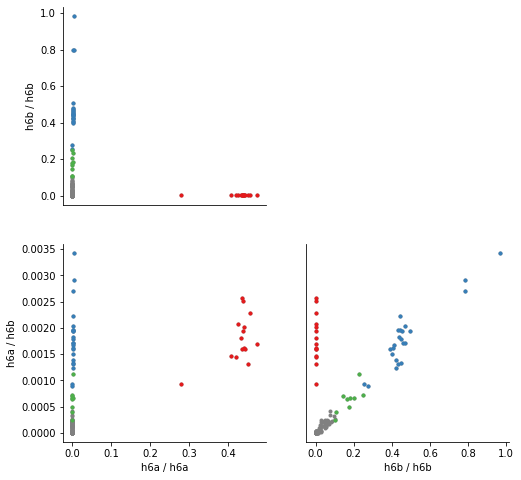

In [39]:
def plotContigs(pair1, pair2, ax):
    pairings_df_new = pairings_df/length_dict[pair1[0]]
    ax.plot(pairings_df_new[pair1].values, pairings_df_new[pair2].values, '.', color='#808080')
    ax.plot(pairings_df_new.loc[high_6a][pair1].values, pairings_df_new.loc[high_6a][pair2].values, '.', color=sns.color_palette("Set1")[0])
    ax.plot(pairings_df_new.loc[high_6b][pair1].values, pairings_df_new.loc[high_6b][pair2].values, '.', color=sns.color_palette("Set1")[1])

    ax.plot(pairings_df_new.loc[med_6b][pair1].values, pairings_df_new.loc[med_6b][pair2].values, '.', color=sns.color_palette("Set1")[2])
    #ax.plot(pairings_df_new.loc[noninherited_6a][pair1].values, pairings_df_new.loc[noninherited_6a][pair2].values, 'x', color='red')
#    ax.plot(pairings_df_new.loc[LCL_hhv_6b_high][pair1].values, pairings_df_new.loc[LCL_hhv_6b_high][pair2].values, '.', color=sns.color_palette("Set1")[3])
#    ax.plot(pairings_df_new.loc[LCL_hhv_6b_med][pair1].values, pairings_df_new.loc[LCL_hhv_6b_med][pair2].values, '.', color=sns.color_palette("Set1")[4])
#    ax.plot(pairings_df_new.loc[infected_hhv_6b][pair1].values, pairings_df_new.loc[infected_hhv_6b][pair2].values, '.', color=sns.color_palette("Set1")[7])
    ax.set_xlabel(' / '.join([p.replace(herpes_6a_contig, 'h6a').replace(herpes_6b_contig, 'h6b').replace(herpes_7_contig, 'h7a').replace(decoy_contig, 'chrDecoy') for p in pair1]))
    ax.set_ylabel(' / '.join([p.replace(herpes_6a_contig, 'h6a').replace(herpes_6b_contig, 'h6b').replace(herpes_7_contig, 'h7a').replace(decoy_contig, 'chrDecoy') for p in pair2]))
    #ax.set_xscale('symlog', linthresh=1)
    #ax.set_yscale('symlog', linthresh=1)
    
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
for i1, p1 in enumerate([(herpes_6a_contig, herpes_6a_contig), (herpes_6b_contig, herpes_6b_contig), 
           (herpes_6a_contig, herpes_6b_contig)]):#, 
#           (decoy_contig, herpes_6a_contig), (decoy_contig, herpes_6b_contig)]):
    
    for i2, p2 in enumerate([((herpes_6a_contig, herpes_6a_contig)), (herpes_6b_contig, herpes_6b_contig), 
           (herpes_6a_contig, herpes_6b_contig)]):#, 
          # (decoy_contig, herpes_6a_contig), (decoy_contig, herpes_6b_contig)]):
        if i1<i2: 
            ax[i2-1, i1].spines['top'].set_visible(False)
            ax[i2-1, i1].spines['right'].set_visible(False)
            plotContigs(p1, p2, ax[i2-1, i1])
            if i1!=0: 
                ax[i2-1, i1].set_ylabel('')
                ax[i2-1, i1].set_yticks([])
            if i2!=2: 
                ax[i2-1,i1].set_xlabel('')
                ax[i2-1,i1].set_xticks([])


for i in range(1):
    for j in range(i+1,2):
        ax[i,j].axis('off')
plt.savefig(FIG_DIR + 'herpes6_ab_count_correlations.svg', transparent=True)
plt.show()


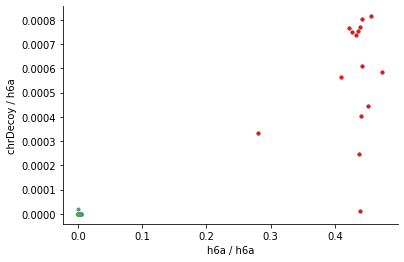

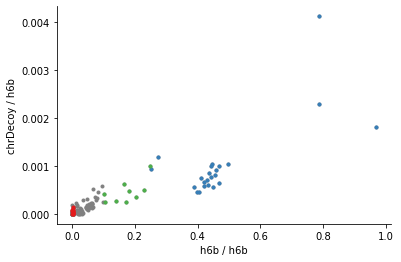

In [40]:
f, ax = plt.subplots()
plotContigs((herpes_6a_contig, herpes_6a_contig), (decoy_contig, herpes_6a_contig), ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(FIG_DIR + 'herpes6a_with_decoy.svg', transparent=True)

plt.show()


f, ax = plt.subplots()
plotContigs((herpes_6b_contig, herpes_6b_contig), (decoy_contig, herpes_6b_contig), ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(FIG_DIR + 'herpes6b_with_decoy.svg', transparent=True)
plt.show()

In [41]:
herpes_6a_contig = 'kraken:taxid|32603|NC_001664.4'
herpes_6b_contig = 'kraken:taxid|32604|NC_000898.1'
herpes_7_contig = 'kraken:taxid|10372|NC_001716.2'
decoy_contig = 'chrUn_JTFH01000690v1_decoy'
length_dict[decoy_contig] = length_dict[herpes_6a_contig]
kraken_to_english_id ={'kraken:taxid|32603|NC_001664.4': 'Human betaherpesvirus 6A',
                      'kraken:taxid|32604|NC_000898.1': 'Human betaherpesvirus 6B',
                      'kraken:taxid|10372|NC_001716.2': 'Human betaherpesvirus 7',
                      'chrUn_JTFH01000690v1_decoy':'chrUn_JTFH01000690v1_decoy'}
df_herpesvirus_unnormed['chrUn_JTFH01000690v1_decoy'] = df_herpesvirus_unnormed[['Human betaherpesvirus 6A', 'Human betaherpesvirus 6B']].sum(axis=1)


def coverage_proper_pairs(contig, samples):
    new_samples = set(samples).intersection(coverages_dict.keys())
    pair = (contig, contig)
    coverages_pair1 = [copy.deepcopy(coverages_dict[k][pair][0]) for k in new_samples if pair in coverages_dict[k]]
    coverages_pair2 = [copy.deepcopy(coverages_dict[k][pair][1]) for k in new_samples if pair in coverages_dict[k]]
    
    for i in range(len(coverages_pair1)):
        total = df_herpesvirus_unnormed.loc[samples[i]][kraken_to_english_id[contig]]/length_dict[contig]#*150
        for key in coverages_pair1[i]:
            coverages_pair1[i][key] /= total

        total = df_herpesvirus_unnormed.loc[samples[i]][kraken_to_english_id[contig]]/length_dict[contig]#*150
        for key in coverages_pair2[i]:
            coverages_pair2[i][key] /= total
            
    counter_all = [sum([c1, c2], Counter()) for c1, c2 in zip(coverages_pair1, coverages_pair2)]
    
    counter_sum = sum(coverages_pair1 + coverages_pair2, Counter())
    return counter_sum, counter_all


def coverage_pairs_diff_contig(contig1, contig2, samples):
    new_samples = set(samples).intersection(coverages_dict.keys())
    pair = (contig1, contig2)
    coverages_pair1 = [copy.deepcopy(coverages_dict[k][pair][0]) for k in new_samples if pair in coverages_dict[k]]
    coverages_pair2 = [copy.deepcopy(coverages_dict[k][pair][1]) for k in new_samples if pair in coverages_dict[k]]
    
    for i in range(len(coverages_pair1)):
        total = df_herpesvirus_unnormed.loc[samples[i]][kraken_to_english_id[contig1]]/length_dict[contig1]
        for key in coverages_pair1[i]:
            coverages_pair1[i][key] /= total

        total = df_herpesvirus_unnormed.loc[samples[i]][kraken_to_english_id[contig2]]/length_dict[contig2]
        for key in coverages_pair2[i]:
            coverages_pair2[i][key] /= total
    
    counter1_all = [sum([c], Counter()) for c in coverages_pair1]
    counter1_sum = sum(coverages_pair1, Counter())
    
    counter2_all = [sum([c], Counter()) for c in coverages_pair2]
    counter2_sum = sum(coverages_pair2, Counter())
    
    return counter1_sum, counter1_all, counter2_sum, counter2_all


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


avg_window = 100


def PlotCoverages(primary_contig, samples, color, primary_contig_name, samples_name):

    cov_sum, cov_all  = coverage_proper_pairs(herpes_6a_contig, samples)

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(length_dict[herpes_6a_contig])}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(length_dict[herpes_6a_contig])}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    #plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('HHV-6A (mated with HHV-6A)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_6A_6A.svg' % samples_name, transparent=True)
    plt.show()

    cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, samples)

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(length_dict[herpes_6b_contig])}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(length_dict[herpes_6b_contig])}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    #plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('HHV-6B (mated with HHV-6B)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_6B_6B.svg' % samples_name, transparent=True)

    plt.show()


    cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, samples)

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all1):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(length_dict[herpes_6a_contig])}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(length_dict[herpes_6a_contig])}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    #plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('HHV-6A (mated with HHV-6B)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_6A_6B.svg' % samples_name, transparent=True)
    plt.show()

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all2):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(length_dict[herpes_6b_contig])}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(length_dict[herpes_6b_contig])}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    #plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('HHV-6B (mated with HHV-6A)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_6B_6A.svg' % (samples_name), transparent=True)
    plt.show()



    cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(decoy_contig, primary_contig, samples)

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all1):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(2000)}
        plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(2000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color=color)
    #plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('Decoy (mated with %s)' % primary_contig_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_decoy_%s.svg' % (samples_name, primary_contig_name), transparent=True)
    plt.show()

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all2):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(length_dict[primary_contig])}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(length_dict[primary_contig])}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    #plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('%s (mated with decoy)' % primary_contig_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_%s_decoy.svg' % (samples_name, primary_contig_name), transparent=True)
    plt.show()


In [42]:
def Plot7Coverages(primary_contig, samples, color, primary_contig_name, samples_name):

    cov_sum, cov_all  = coverage_proper_pairs(herpes_7_contig, samples)

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(length_dict[herpes_7_contig])}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(length_dict[herpes_7_contig])}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    #plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('HHV-7 (mated with HHV-7)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + 'HHV7_%s.svg' % samples_name, transparent=True)

    plt.show()


 
    


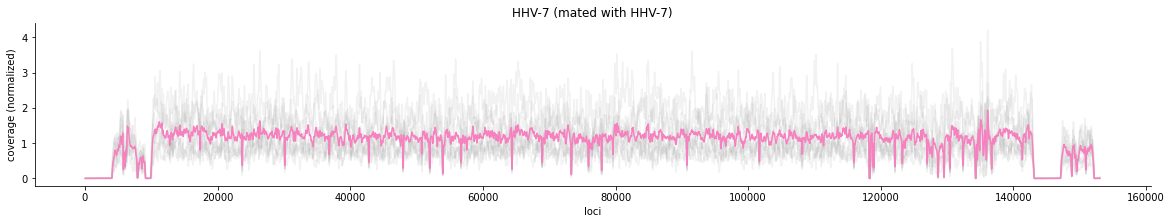

In [43]:
Plot7Coverages(herpes_7_contig, high_7, sns.color_palette("Set1")[7], 'HHV-7', '7high')

In [44]:
sns.color_palette("Set1")

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

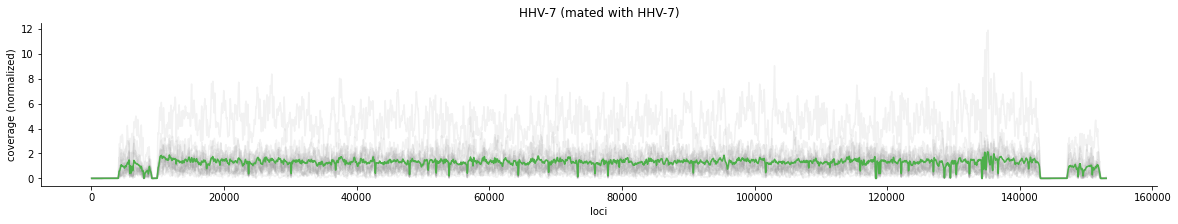

In [45]:
Plot7Coverages(herpes_7_contig, med_7, sns.color_palette("Set1")[2], 'HHV-7', '7med')

# Proper Pairs

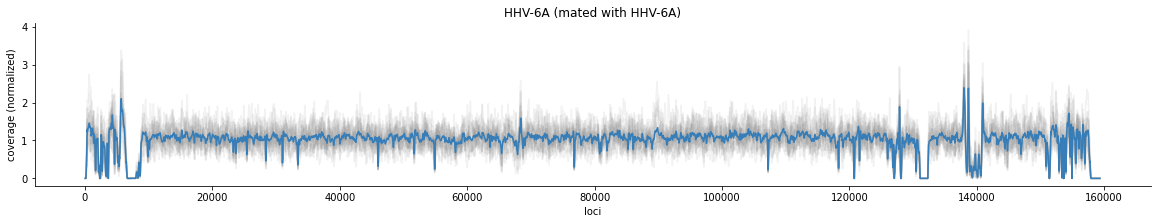

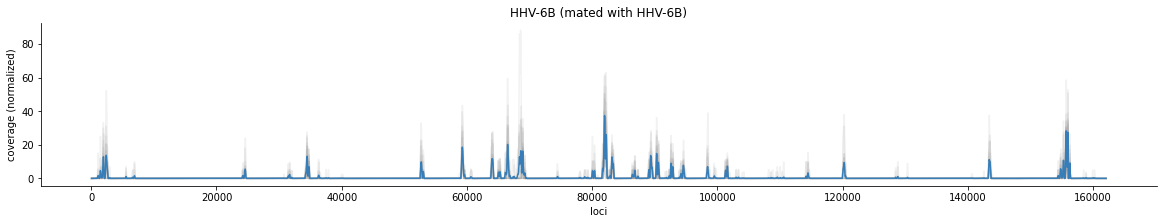

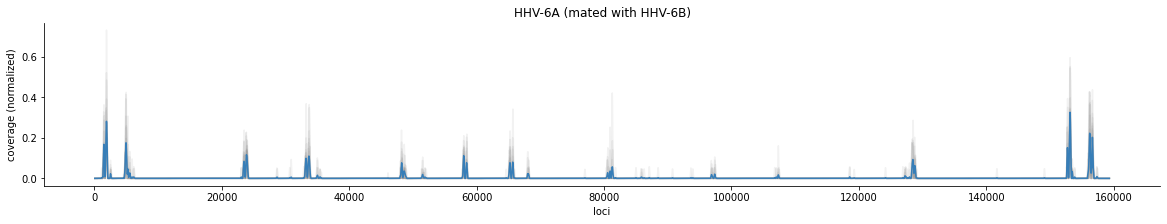

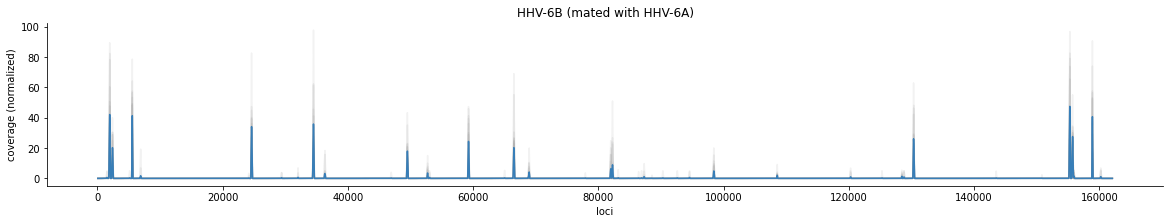

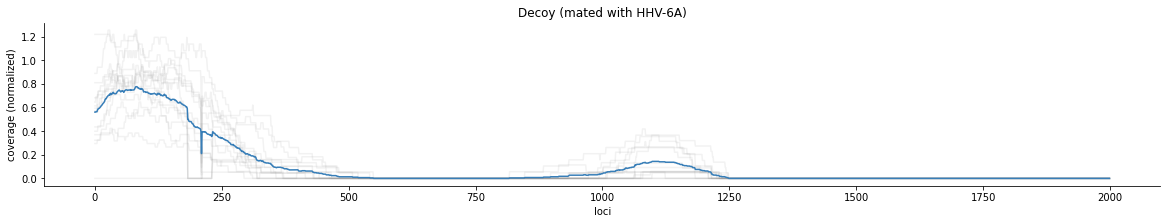

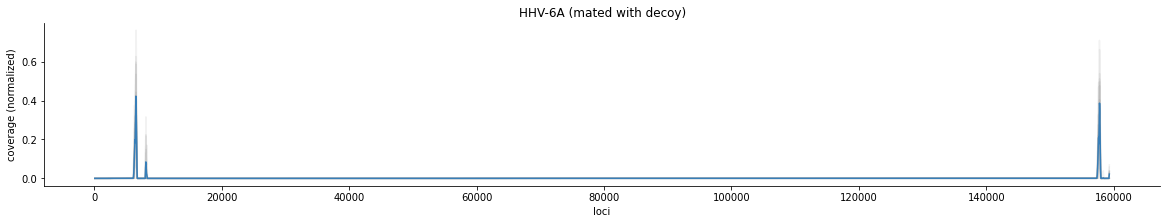

In [46]:
PlotCoverages(herpes_6a_contig, high_6a, sns.color_palette("Set1")[1], 'HHV-6A', 'ici6A')

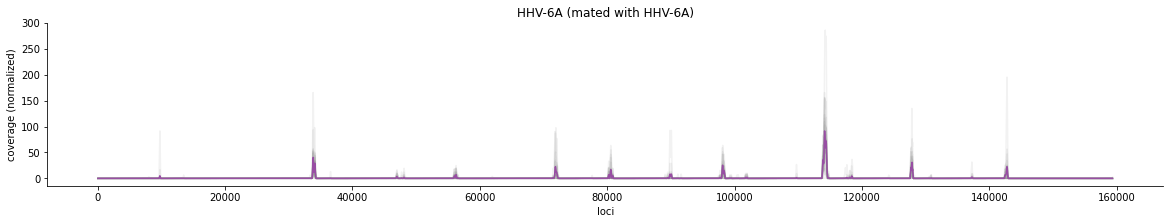

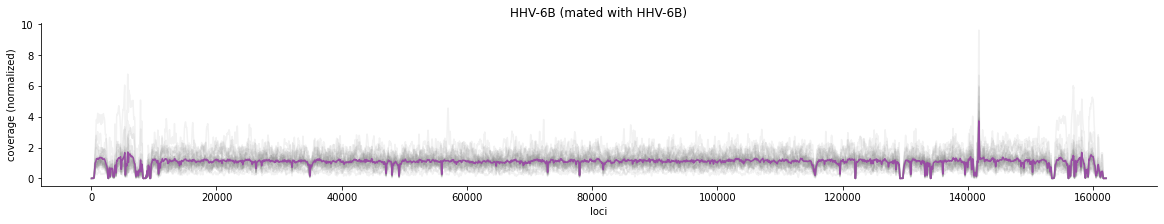

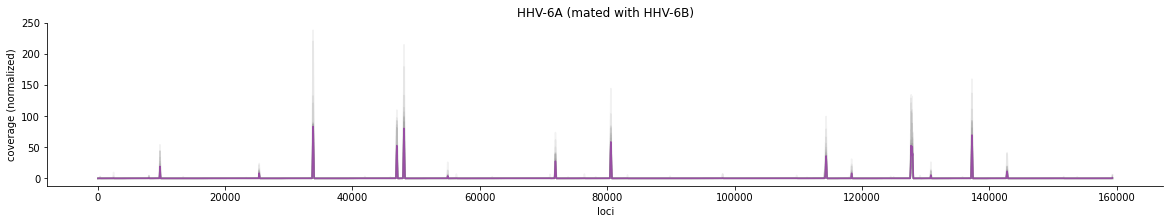

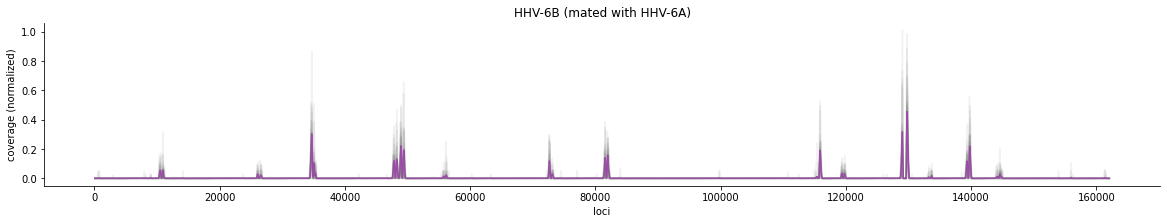

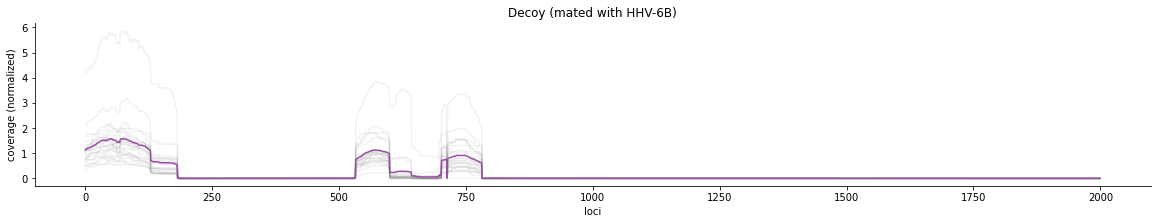

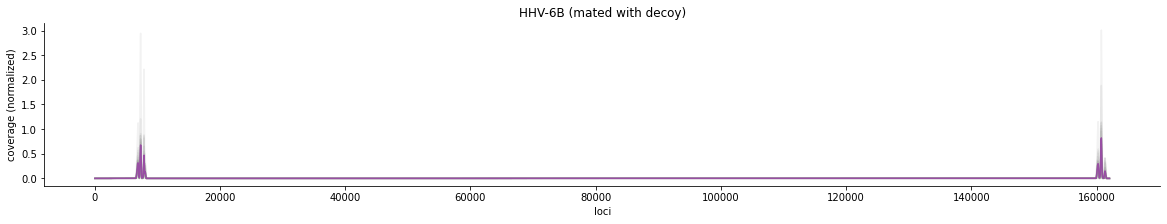

In [47]:
PlotCoverages(herpes_6b_contig, high_6b, sns.color_palette("Set1")[3], 'HHV-6B', 'high_6b')

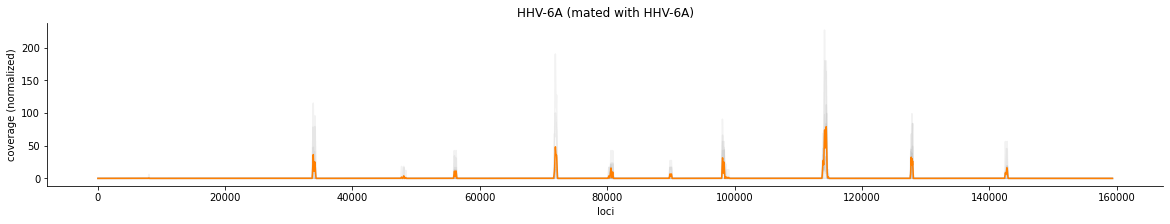

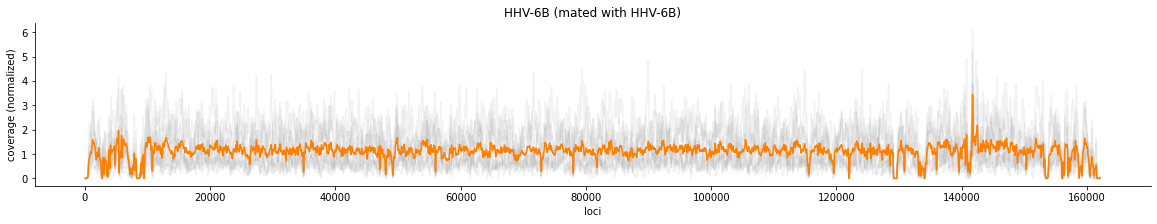

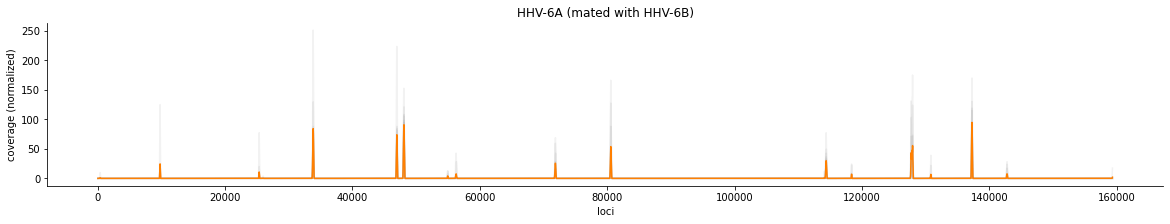

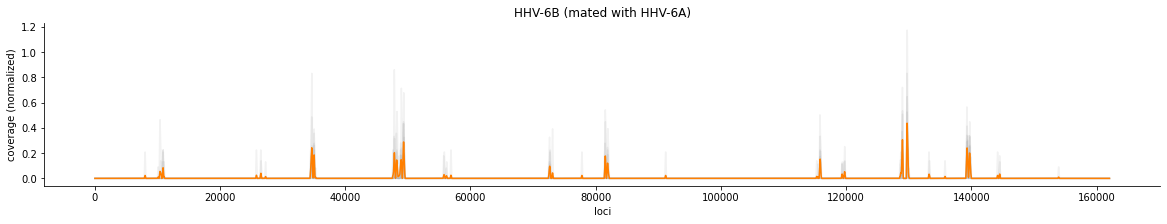

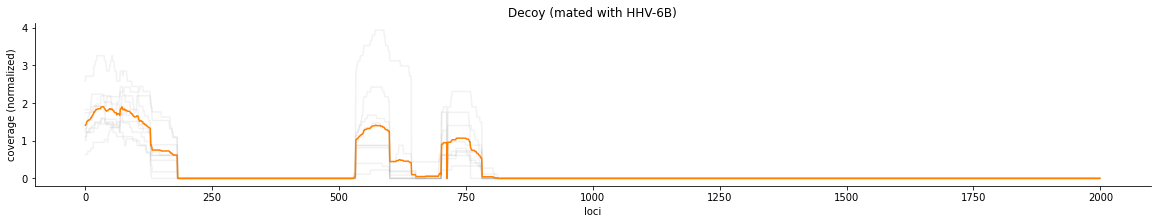

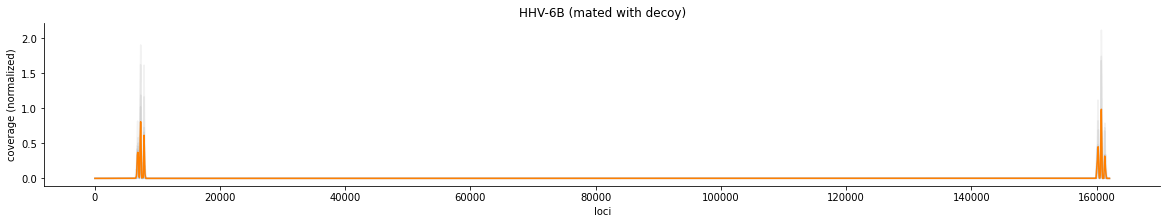

In [48]:
PlotCoverages(herpes_6b_contig, med_6b, sns.color_palette("Set1")[4], 'HHV-6B', 'med_6b')

In [49]:
cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(decoy_contig, herpes_6a_contig, icihhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(2000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(2000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with decoy)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

NameError: name 'icihhv_6a' is not defined

In [ ]:
cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, icihhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(1000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, LCL_hhv_6b_high)


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(1000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, LCL_hhv_6b_med)


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(1000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
cov_sum, cov_all  = coverage_proper_pairs(herpes_6a_contig, infected_hhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, infected_hhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, infected_hhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


In [ ]:
cov_sum, cov_all  = coverage_proper_pairs(herpes_6a_contig, LCL_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, LCL_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, LCL_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


# Decoy Contig Seq

In [ ]:
decoy_seq = [r for r in SeqIO.read(
    '/home/groups/dpwall/briannac/general_data/reference_genomes/GRCh38_reference_genome/' + 
    'GRCh38_full_analysis_set_plus_decoy_hla.fa', 'fasta') if
 r.id=='chrUn_JTFH01000690v1_decoy']



In [ ]:
cov_sum, cov_all  = coverage_proper_pairs(herpes_6a_contig, infected_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, infected_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, infected_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


In [ ]:
cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, infected_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6B)')
plt.show()


#cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, list(h6b_med))

#f, ax = plt.subplots(figsize=(20,3))
#for idx, cov_i in enumerate(cov_all):
#    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
#    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
#loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
#plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
#plt.yscale('symlog', linthresh=1e-7)
#plt.xlabel('loci')
#plt.ylabel('coverage (normalized)')
#plt.title('HHV-6B (mated with HHV-6B)')
#plt.show()

In [ ]:
cov_sum, cov_all  = coverage_proper_pairs(herpes_7_contig, h7_high)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#87bc45')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-7 (mated with HHV-7)')
plt.show()




cov_sum, cov_all  = coverage_proper_pairs(herpes_7_contig, h7_med)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#87bc45')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-7 (mated with HHV-7)')
plt.show()

# Paired With Different HHV

In [ ]:
cov1_sum, cov1_all, cov2_sum, cov2_all  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, icihhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B), iciHHV-6A samples')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A), iciHHV-6A samples')
plt.show()






cov1_sum, cov1_all, cov2_sum, cov2_all  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, infected_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B), iciHHV-6B samples')
plt.show()


#f, ax = plt.subplots(figsize=(20,3))
#for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A), iciHHV-6B samples')
plt.show()





cov1_sum, cov1_all, cov2_sum, cov2_all  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, infe)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B), medium 6B samples')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A), medium 6B samples')
plt.show()

# Paired with Decoy

In [ ]:
cov2_sum, cov2_all, cov1_sum, cov1_all  = coverage_pairs_diff_contig(decoy_contig, herpes_6a_contig, icihhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with decoy)')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1500)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(1500)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy contig (mated with HHV-6A)')
plt.show()

In [ ]:
cov2_sum, cov2_all, cov1_sum, cov1_all  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, noninherited_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with decoy)')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1500)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(1500)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy contig (mated with HHV-6B)')
plt.show()

In [ ]:
cov2_sum, cov2_all, cov1_sum, cov1_all  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, icihhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with decoy)')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1500)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(1500)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy contig (mated with HHV-6B)')
plt.show()

In [ ]:
cov2_sum, cov2_all, cov1_sum, cov1_all  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, h6b_high)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with decoy)')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1500)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(1500)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy contig (mated with HHV-6B)')
plt.show()

In [ ]:
cov2_sum, cov2_all, cov1_sum, cov1_all  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, h6b_med)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with decoy)')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1500)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(1500)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy contig (mated with HHV-6B)')
plt.show()

# Double Checking sequencing plate

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

from tqdm import tqdm
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.feature_selection import f_regression
from sklearn import metrics
colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

BLOOD_MICROBIOME_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
F_REGRESSION_RESULTS = BLOOD_MICROBIOME_DIR + 'results/f_regression/f_regression_results.csv'
BAM_MAPPINGS_FILE = BLOOD_MICROBIOME_DIR + 'data/bam_mappings.csv'
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)


In [ ]:
f_regress_results = pd.read_csv(F_REGRESSION_RESULTS, header=None)
f_regress_results.drop(0, inplace=True, axis=1)
f_regress_results.columns = ['name', 'exog_value', 'coeff']
f_regress_results['coeff_abs'] = abs(f_regress_results.coeff)

In [ ]:
f_regress_results[f_regress_results.name=='Human betaherpesvirus 7']

# Whole blood vs LCL on same samples

In [ ]:
# HHV-6A

In [ ]:
LCL_samples = [(b, b.replace('_LCL', '')) for b in bam_mappings.index if '_' in str(b)]
dup_samples = [(i,j) for i,j in LCL_samples if (i in df_virus.index) and (j in df_virus.index)]
LCL_samples = [i for i,_ in dup_samples]
WB_samples = [j for _,j in dup_samples]


In [ ]:
plt.plot(df_virus.loc[WB_samples]['Human betaherpesvirus 6B'].values, df_virus.loc[LCL_samples]['Human betaherpesvirus 6B'].values, '.', color='blue')
plt.plot(df_virus.loc[WB_samples]['Human betaherpesvirus 7'].values, df_virus.loc[LCL_samples]['Human betaherpesvirus 7'].values, '.', color='red')

plt.xlabel('WB sample')
plt.ylabel('LCL sample')
plt.xlim(-.1,8000)
plt.ylim(-.1,8000)
plt.xscale('symlog')
plt.yscale('symlog')
plt.show('HHV-6B')


In [ ]:
pairings_melt = pairings_df.melt()

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(data=pairings_melt,x='variable', y='value')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
#plt.yscale('symlog')
plt.show()

In [ ]:
def PrepCounterForPlot(coverage_counts):
    loci = np.array([int(i) for i in list(coverage_counts.keys())])
    counts = np.array([int(i) for i in list(coverage_counts.values())])
    counts = counts[np.argsort(loci)]
    loci = sorted(loci)
    #loci_set = set(loci)
    avg_counts = np.zeros(int(max(loci))-int(min(loci)))
    avg_counts[loci-min(loci)-1]  = list(counts)
    loci = np.array([i for i in range(min(loci), max(loci))])
    return pd.Series(loci).rolling(window=1000).mean(), pd.Series(avg_counts).rolling(window=1000).mean() # Return rolling average for cleaner plots.

In [ ]:
pair = pairings_df.columns[0]
samples = set(h6a_high).intersection(coverages_dict.keys())
covs_1 = [coverages_dict[k][pair][0] for k in samples if pair in coverages_dict[k]]
covs_2 = [coverages_dict[k][pair][1] for k in samples if pair in coverages_dict[k]]

In [ ]:
herpes_6b_contig

In [ ]:
selected_cov=covs_1
for covs in selected_cov:
    loci, avg_counts = PrepCounterForPlot(covs)
    plt.plot(loci, avg_counts, color=(.8,.8,.8))
counter_sum = sum(selected_cov, Counter())
loci, avg_counts = PrepCounterForPlot(counter_sum)
plt.plot(loci, avg_counts/len(selected_cov), 'orange')
plt.show()

selected_cov=covs_2
for covs in selected_cov:
    loci, avg_counts = PrepCounterForPlot(covs)
    plt.plot(loci, avg_counts, color=(.8,.8,.8))
counter_sum = sum(selected_cov, Counter())
loci, avg_counts = PrepCounterForPlot(counter_sum)
plt.plot(loci, avg_counts/len(selected_cov), 'orange')
plt.show()


In [ ]:
selected_cov=covs_1
for covs in selected_cov:
    loci, avg_counts = PrepCounterForPlot(covs)
    plt.plot(loci, avg_counts, color=(.8,.8,.8))
counter_sum = sum(selected_cov, Counter())
loci, avg_counts = PrepCounterForPlot(counter_sum)
plt.plot(loci, avg_counts/len(selected_cov), 'orange')
plt.show()

selected_cov=covs_2
for covs in selected_cov:
    loci, avg_counts = PrepCounterForPlot(covs)
    plt.plot(loci, avg_counts, color=(.8,.8,.8))
counter_sum = sum(selected_cov, Counter())
loci, avg_counts = PrepCounterForPlot(counter_sum)
plt.plot(loci, avg_counts/len(selected_cov), 'orange')
plt.show()



In [ ]:
counter_sum = sum(covs_1[:100], Counter())

In [ ]:
np.array(list(counter_sum.values()))[np.argsort(list(counter_sum.keys()))]

In [ ]:
len(np.argsort(list(counter_sum.keys())))

In [ ]:
max(loci)

In [ ]:
loci = np.array([int(i) for i in list(counter_sum.keys())])
counts = np.array([int(i) for i in list(counter_sum.values())])
counts = counts[np.argsort(loci)]
loci = sorted(loci)
#loci_set = set(loci)
avg_counts = np.zeros(int(max(loci))-int(min(loci)))
avg_counts[loci-min(loci)-1]  = list(counts)
loci = np.array([i for i in range(min(loci), max(loci))])
#list(counter_sum.values()))[np.argsort(list(counter_sum.keys()))]
#plt.plot([l for l in range(int(min(loci)), int(max(loci)))], [avg_counts[i] if l in loci_set else 0 for i,l in enumerate(range(int(min(loci)), int(max(loci))))], '-')

In [ ]:
plt.plot(loci, avg_counts)

In [ ]:

pair = ('kraken:taxid|10372|NC_001716.2', 'kraken:taxid|10372|NC_001716.2')

coverages_dict[k][pair][0].keys()

In [ ]:
df_virus = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/df_virus_filtered.csv', index_col=0)
df_virus.index = [i.split(' -')[0] for i in df_virus.index]
bam_mappings = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/data/bam_mappings.csv', sep='\t', index_col=1)

In [ ]:
def saveHighResFig(fig_name):
    plt.tight_layout()
    plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/%s.png' % fig_name, 
                transparent=True, bbox_inches='tight', format='png', dpi=500)

In [ ]:
def GetCoverage(sample, contig_names, save_file):
    batch = bam_mappings.loc[sample].get('sequencing_plate').replace('MTR-', '')
    decoy_contig = 'chrUn_JTFH01000690v1_decoy'

    # Extract reads    
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.paired.aln_all.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        proper_reads = [r  for c in contig_names for r in samfile.fetch(c) if (~r.is_supplementary & ~r.is_secondary)]
    #with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.paired.aln_all.bam" % (batch, sample, sample), "r") as samfile:
    #    improper_reads = [r  for c in contig_names for r in samfile.fetch(c) if (~r.is_proper_pair & ~r.is_supplementary & ~r.is_secondary)]
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.paired.aln_all.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        mated_with_unmapped_reads = [r  for c in contig_names for r in samfile.fetch(c) if (r.mate_is_unmapped & ~r.is_supplementary & ~r.is_secondary)]
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.single.aln_all.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        mated_with_ref_genome_dict = {r.query_name:r for c in contig_names for r in samfile.fetch(c) if (~r.is_supplementary & ~r.is_secondary)}
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.map_unmap.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        decoy_dict = {r.query_name:r for r in samfile.fetch(decoy_contig)}
    
    # Compute coverage
    decoy_pair_keys = set(decoy_dict.keys()).intersection(set(mated_with_ref_genome_dict.keys()))
    decoy_reads = [decoy_dict[i] for i in decoy_pair_keys]
    mated_with_decoy_reads = [mated_with_ref_genome_dict[i] for i in decoy_pair_keys]
    
    proper_pair_ids = Counter([p.query_name for p in proper_reads])
    proper_reads_same_chrom = [p for p in proper_reads if proper_pair_ids[p.query_name]==2]
        
    if len(proper_reads)>0: proper_coverage = np.concatenate([r.get_reference_positions() for r in proper_reads])
    else: proper_coverage = []
    #if len(improper_reads)>0: improper_coverage = np.concatenate([r.get_reference_positions() for r in improper_reads])
    #else: improper_coverage = []
    if len(mated_with_decoy_reads)>0: mated_with_decoy_coverage = np.concatenate([r.get_reference_positions() for r in mated_with_decoy_reads])
    else: mated_with_decoy_coverage = []
    if len(mated_with_unmapped_reads)>0:  mated_with_unmapped_coverage = np.concatenate([r.get_reference_positions() for r in mated_with_unmapped_reads])
    else: mated_with_unmapped_coverage = []
    if len(decoy_reads)>0: decoy_coverage = np.concatenate([r.get_reference_positions() for r in decoy_reads])
    else: decoy_coverage = []
    
    # Create and save dictionary.
    coverage_dict = dict()
    coverage_dict['proper_coverage'] = proper_coverage
    #coverage_dict['improper_coverage'] = improper_coverage
    coverage_dict['mated_with_decoy_coverage'] = mated_with_decoy_coverage
    coverage_dict['mated_with_unmapped_coverage'] = mated_with_unmapped_coverage
    coverage_dict['decoy_coverage'] = decoy_coverage
    np.save(save_file, coverage_dict)
    for f in glob.glob('%s.*.bai' % sample):
        os.remove(f)
    return coverage_dict
    
    

def CoverageHistograms(coverage_dicts, bins_virus, bins_decoy):
    f, ax = plt.subplots(ncols=4,figsize=(25,3))
    n_avg_paired = np.zeros(len(bins_virus)-1)
    #n_avg_improper = np.zeros(len(bins_virus)-1)
    n_avg_paired_with_unmapped = np.zeros(len(bins_virus)-1)
    n_avg_paired_with_decoy = np.zeros(len(bins_virus)-1)
    n_avg_decoy_seq = np.zeros(len(bins_decoy)-1)

    for s in coverage_dicts.keys():
        
        # Virus-Virus coverage:
        n,_ = np.histogram(coverage_dicts[s]['proper_coverage'], bins=bins_virus)
        n_avg_paired = n_avg_paired + n/sum(n)
        ax[0].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)
        
        # Virus-Virus coverage:
        #n,_ = np.histogram(coverage_dicts[s]['improper_coverage'], bins=bins_virus)
        #n_avg_improper = n_avg_improper + n/sum(n)
        #ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)

        # Virus-Unmapped coverage
        if len(coverage_dicts[s]['mated_with_unmapped_coverage'])>0:
            n,_ = np.histogram(coverage_dicts[s]['mated_with_unmapped_coverage'], bins=bins_virus)
            n_avg_paired_with_unmapped = n_avg_paired_with_unmapped + n/sum(n)
            ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)

        else:
            ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, 0*bins_virus[1:], color='grey', alpha=.3)

        # Virus-decoy pairs
        if len(coverage_dicts[s]['mated_with_decoy_coverage'])>0:
            n,_ = np.histogram(coverage_dicts[s]['mated_with_decoy_coverage'], bins=bins_virus)
            n_avg_paired_with_decoy = n_avg_paired_with_decoy + n/sum(n)
            ax[2].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)
            
            n,_ = np.histogram(coverage_dicts[s]['decoy_coverage'], bins=bins_decoy)
            n_avg_decoy_seq = n_avg_decoy_seq + n/sum(n)
            ax[3].plot((bins_decoy[1:]+bins_decoy[:-1])/2, n/sum(n), color='grey', alpha=.5)

        else:
            ax[2].plot((bins_virus[1:]+bins_virus[:-1])/2, 0*bins_virus[1:], color='grey', alpha=.3)
            ax[3].plot((bins_decoy[1:]+bins_decoy[:-1])/2, 0*bins_decoy[1:], color='grey', alpha=.5)
            
            
    ax[0].plot((bins_virus[1:]+bins_virus[:-1])/2, n_avg_paired/len(coverage_dicts), color='orange', alpha=1)
    ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, n_avg_paired_with_unmapped/len(coverage_dicts), color='orange', alpha=1)
    ax[2].plot((bins_virus[1:]+bins_virus[:-1])/2, n_avg_paired_with_decoy/len(coverage_dicts), color='orange', alpha=1)
    ax[3].plot((bins_decoy[1:]+bins_decoy[:-1])/2, n_avg_decoy_seq/len(coverage_dicts), color='orange', alpha=1)

    for i in range(4):
        ax[i].set_yticks([])
        ax[i].set(frame_on=False)
        ax[i].locator_params(nbins=5)

In [ ]:
df_virus = df_virus[['Human herpesvirus 6A', 'Human herpesvirus 6B', 'Human herpesvirus 7', 'type','family']]

In [ ]:
herpes_7_contigs = {'AF037218.1','KF558370.1', 'MH507176.1','MH507177.1','MK619207.1','MT314265.1','MT314266.1','MT314267.1','MT314268.1',
                    'MT314269.1','NC_001716.2','VIRL|gi|51874225|ref|NC_001716.2|'}
herpes_6A_contigs =  {'JX152762.1','KC465951.1','KP026965.1','KP257584.1','KT355575.1','KY316047.1','KY316048.1',
                      'KY316049.1','KY316054.1','KY316055.1','KY316056.1','MF994813.1','MF994815.1','MF994816.1',
                      'MF994817.1','MF994818.1','MF994819.1','MF994820.1','MF994822.1','MF994828.1','MH698400.1',
                      'MH698403.1','MK630133.1','MK630134.1','MN079022.1','MN079023.1','MN079024.1','NC_001664.4',
                      'U04437.1','U13194.1','U23467.1','VIRL|gi|224020395|ref|NC_001664.2|','X83413.2'}
herpes_6B_contigs = {'EU861010.1','EU861011.1','EU861012.1','EU861013.1','EU861014.1','EU861015.1','EU861016.1','EU861017.1','EU861018.1',
                     'EU861019.1','EU861020.1','EU861021.1','EU861022.1','EU861023.1','EU861024.1','EU861025.1','EU861026.1','EU861027.1',
                     'EU861028.1','FJ610376.1','FJ610377.1','FJ610378.1','FJ610379.1','FJ610380.1','FJ610381.1','FJ610382.1','FJ610383.1',
                     'FJ610384.1','FJ610385.1','FJ610386.1','FJ610387.1','FJ610388.1','FJ610389.1','FJ610390.1','FJ610391.1','FJ610392.1',
                     'FJ610393.1','FJ610394.1','FJ610395.1','FJ610396.1','FJ610397.1','FJ610398.1','FJ610399.1','FJ610400.1','FJ610401.1',
                     'FJ610402.1','FJ610403.1','FJ610404.1','FJ610405.1','FJ610406.1','FJ610407.1','FJ610408.1','FJ610409.1','FJ610410.1',
                     'FJ610411.1','FJ610412.1','FJ610413.1','FJ610414.1','FJ610415.1','FJ610416.1','FJ610417.1','FJ610418.1','FJ610419.1',
                     'FJ610420.1','FJ610421.1','FJ610422.1','FJ610423.1','FJ610424.1','FJ610425.1','FJ610426.1','FJ610427.1','FJ610428.1',
                     'FJ610429.1','FJ610430.1','FJ610431.1','FJ610432.1','FJ610433.1','FJ610434.1','FJ610435.1','FJ610436.1','FJ610437.1',
                     'FJ610438.1','JX235339.1','KF130944.1','KF130945.1','KF130946.1','KF130947.1','KX595170.1','KY316030.1','KY316031.1',
                     'KY316032.1','KY316033.1','KY316034.1','KY316035.1','KY316036.1','KY316037.1','KY316038.1','KY316039.1','KY316040.1',
                     'KY316041.1','KY316042.1','KY316043.1','KY316044.1','KY316045.1','KY316046.1','KY316050.1','KY316051.1','KY316052.1',
                     'KY316053.1','MF624253.1','MF624254.1','MF624255.1','MF624256.1','MF624257.1','MF624258.1','MF624259.1','MF624260.1',
                     'MF624261.1','MF624262.1','MF624263.1','MF994814.1','MF994821.1','MF994823.1','MF994824.1','MF994825.1','MF994826.1',
                     'MF994827.1','MF994829.1','MH507178.1','MH698398.1','MH698399.1','MH698401.1','MH698402.1','MK388090.1','MK629887.1',
                     'MK629888.1','MK629889.1','MK629890.1','MK629891.1','MK629892.1','MK629893.1','MK629894.1','MK629895.1','MK629896.1',
                     'MK629897.1','MK629898.1','MK629899.1','MK629900.1','MK629901.1','MK629902.1','MK629903.1','MK629904.1','MK629905.1',
                     'MK629906.1','MK629907.1','MK629908.1','MK629909.1','MK629910.1','MK629911.1','MK629912.1','MK629913.1','MK629914.1',
                     'MK629915.1','MK629916.1','MK629917.1','MK629918.1','MK629919.1','MK629920.1','MK629921.1','MK629922.1','MK629923.1',
                     'MK629924.1','MK629925.1','MK629926.1','MK629927.1','MK629928.1','MK629929.1','MK629930.1','MK629931.1','MK629932.1',
                     'MK629933.1','MK629934.1','MK629935.1','MN242397.1','NC_000898.1', 'VIRL|gi|9633069|ref|NC_000898.1|'}


# General Abundances

In [ ]:
df_melt = df_virus.melt(id_vars=['type','family'])
plt.figure(figsize=(5,3))
sns.stripplot(data=df_melt, y='value', x='variable', hue='type',jitter=.3,palette=['#ff9900', '#8687d1'], dodge=True)
plt.yscale("symlog", linthresh=10)
plt.ylim(0,df_melt['value'].max().max()*2)
yaxis = plt.gca().yaxis
plt.legend().remove()
plt.xticks([])
yaxis.set_minor_locator(MinorSymLogLocator(10))
plt.tight_layout()
plt.box(on=None)
saveHighResFig('herpes_abundances_vs_cell_type')
plt.show()

In [ ]:
Counter([(i,j) for i,j in zip(df_virus['Human herpesvirus 6B']>1000, bam_mappings.loc[df_virus.index].relationship=='sibling')])

In [ ]:
288/1798

In [ ]:
sns.scatterplot(data=df_virus, y='Human herpesvirus 6A', x='Human herpesvirus 6B', hue='type',palette=['#8687d1', '#ff9900'])
plt.xscale("symlog", linthresh=10)
plt.yscale("symlog", linthresh=10)
plt.ylim(-1,10**5)
plt.xlim(-1,10**5)
plt.box(on=None)

plt.legend().remove()
plt.show()

^ Note that the cluster of WB 6A around ~10 look like they are actually reads coming from H6B.

# Herpesvirus 6A
This should be pretty straightforward. Very clear cluster at expected abundance levels of germline integration of 6A.

In [ ]:
bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6A']>1000].sort_values('family').index].bio_seq_source

^ Except for one weird sample, no evidence of de novo integration. No children showed germline integration without parents.

**03C16028** -- this is the weird sample that looks like de novo herpes 6A AND de novo herpes 6B germline, and has a TON of herpes 6B

In [ ]:
print(df_virus['Human herpesvirus 6A'].loc[bam_mappings[bam_mappings.family=='AU0164'].index])
bam_mappings[bam_mappings.family=='AU0164']

## Herpes 6A -- Germline integration.

In [ ]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_6A_'
contig_names = {'VIRL|gi|224020395|ref|NC_001664.2|','NC_001664.4'}
    
coverage_dicts = dict()
for sample in bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6A']>1000].sort_values('family').index].iloc[1:].index:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6A_high')
plt.show()

## Herpes 6A -- Sample 03C16028.

In [ ]:
# Read in the weird sample for later use.
coverage_dicts = dict()
sample='03C16028'
filename = coverage_dir + sample + '.npy'
try: coverage_didcts[sample] = np.load(filename, allow_pickle=True).item()
except:
    coverage_dicts[sample] = GetCoverage(sample, {'VIRL|gi|224020395|ref|NC_001664.2|','NC_001664.4'}, filename)
CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6A_03C16028')

## Herpes 6A -- No integration

In [ ]:
coverage_dicts = dict()
for sample in df_virus[(df_virus['Human herpesvirus 6A']<1000) & (df_virus['Human herpesvirus 6A']>10)].sort_values('family').index:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        print('retrieving sample ', sample)
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6A_low')
plt.show()

In [ ]:
herpes_6A = df_virus[(df_virus['Human herpesvirus 6A']>1000)].index
coverage_dicts = dict()
for sample in herpes_6A:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

samples = list(coverage_dicts.keys())
decoy_coverage = np.array([len(coverage_dicts[c]['decoy_coverage'])/len(np.unique(coverage_dicts[c]['decoy_coverage'])) for c in coverage_dicts])
mated_w_decoy_coverage = np.array([len(coverage_dicts[c]['mated_with_decoy_coverage'])/len(np.unique(coverage_dicts[c]['mated_with_decoy_coverage'])) for c in coverage_dicts])
proper_coverage = np.array([len(coverage_dicts[c]['proper_coverage'])/160000 for c in coverage_dicts])
mated_with_unmapped_coverage = np.array([len(coverage_dicts[c]['mated_with_unmapped_coverage'])/len(np.unique(coverage_dicts[c]['mated_with_unmapped_coverage'])) for c in coverage_dicts])
df = pd.DataFrame([decoy_coverage, mated_w_decoy_coverage, proper_coverage, mated_with_unmapped_coverage]).transpose()
df.columns = ['decoy_coverage', 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']


for x in ['proper_coverage']:#, 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']:
    for y in ['decoy_coverage']:#, 'mated_w_decoy_coverage', '', 'mated_with_unmapped_coverage']:
        if x<=y: continue
        plt.figure(figsize=(10,10))
        g=sns.jointplot(data=df, x=x, y=y, palette=['#8687d1', '#3b5c36'], height=4)
        g.ax_joint.legend().remove()
        g.ax_marg_x.set_xlim(0, 40)
        g.ax_marg_y.set_ylim(0, 40)
        plt.xlabel('total reads ratio')
        plt.ylabel('decoy:virus ratio')
        plt.tight_layout()
        plt.show()
#plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/herpes_6A_total_vs_decoy.png', transparent=True, bbox_inches='tight', format='png', dpi=500)


# Herpes 6B

## Herpes 6B -- Highly suspected ancient integration

At least 2 family members have > 10000 reads.

In [ ]:
herpes_6B_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index]
fams = herpes_6B_high.groupby('family').count()
herpes_6B_high[[f in list(fams[fams.status>1].index) for f in herpes_6B_high.family]]

In [ ]:
df_virus.loc[herpes_6B_de_novo]['type']

In [ ]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_6B_'
contig_names = {'VIRL|gi|9633069|ref|NC_000898.1|'}

herpes_6B_inherited = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index]
fams = herpes_6B_inherited.groupby('family').count()
herpes_6B_inherited = herpes_6B_inherited[[f in list(fams[fams.status>1].index) for f in herpes_6B_inherited.family]].index

coverage_dicts = dict()
for sample in herpes_6B_inherited:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_inherited')
plt.show()

In [ ]:
print(Counter(df_virus.loc[herpes_6B_inherited]['type']))
print(Counter(df_virus['type']))

## Herpes 6B -- possible de novo integration

In [ ]:

herpes_6B_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 7']>10000].sort_values('family').index]
fams = herpes_6B_high.groupby('family').count()
Counter(herpes_6B_high[[f in list(fams[fams.status>0].index) for f in herpes_6B_high.family]].bio_seq_source)
#Counter(bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index].bio_seq_source)

In [ ]:
fam='AU1965'
print(df_virus['Human herpesvirus 7'].loc[set(bam_mappings[bam_mappings.family==fam].index).intersection(set(df_virus.index))])
bam_mappings[bam_mappings.family==fam]

In [ ]:
herpes_6B_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index]
fams = herpes_6B_high.groupby('family').count()
herpes_6B_de_novo = ['03C15783','06C61448', '07C66885','05C48098', '09C90889','02C10855', '02C10954'] # Keep track of which samples look like de novo.


coverage_dicts = dict()
for sample in herpes_6B_de_novo:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_de_novo')
plt.show()



## Herpes 6B -- LCL integration

In [ ]:
print(Counter(df_virus.loc[herpes_6B_de_novo]['type']))
print(Counter(df_virus['type']))

In [ ]:
df_virus[(df_virus['Human herpesvirus 6B']>1000) & (df_virus['Human herpesvirus 6B']<10000)].sort_values('family').index


In [ ]:
Counter( bam_mappings.loc[df_virus[(df_virus['Human herpesvirus 7']>1000) & (df_virus['Human herpesvirus 7']<10000)].sort_values('family').index].bio_seq_source)

In [ ]:
herpes_6B_medium = df_virus[(df_virus['Human herpesvirus 6B']>1000) & (df_virus['Human herpesvirus 6B']<10000)].sort_values('family').index
coverage_dicts = dict()
for sample in herpes_6B_medium:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)
CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_medium')
plt.show()

# Herpes 6B -- Not integrated

In [ ]:
herpes_6B_low = df_virus[(df_virus['Human herpesvirus 6B']<500) & (df_virus['Human herpesvirus 6B']>10)].sort_values('family').index
coverage_dicts = dict()
for sample in herpes_6B_low:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)
CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_low')
plt.show()

In [ ]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_6B_'
contig_names = {'VIRL|gi|9633069|ref|NC_000898.1|'}

herpes_6B = df_virus[(df_virus['Human herpesvirus 6B']>10)].index
coverage_dicts = dict()
for sample in herpes_6B:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

samples = list(coverage_dicts.keys())
decoy_coverage = np.array([len(coverage_dicts[c]['decoy_coverage'])/(len(np.unique(coverage_dicts[c]['decoy_coverage']))+1) for c in coverage_dicts])
mated_w_decoy_coverage = np.array([len(coverage_dicts[c]['mated_with_decoy_coverage'])/(1+len(np.unique(coverage_dicts[c]['mated_with_decoy_coverage']))) for c in coverage_dicts])
proper_coverage = np.array([len(coverage_dicts[c]['proper_coverage'])/160000 for c in coverage_dicts])
mated_with_unmapped_coverage = np.array([len(coverage_dicts[c]['mated_with_unmapped_coverage'])/(1+len(np.unique(coverage_dicts[c]['mated_with_unmapped_coverage']))) for c in coverage_dicts])
df = pd.DataFrame([decoy_coverage, mated_w_decoy_coverage, proper_coverage, mated_with_unmapped_coverage]).transpose()
df.columns = ['decoy_coverage', 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']
df['colors'] = ['likely inherited' if i in herpes_6B_inherited else 'unknown' for i in samples]

In [ ]:
for x in ['proper_coverage']:#, 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']:
    for y in ['decoy_coverage']:#, 'mated_w_decoy_coverage', '', 'mated_with_unmapped_coverage']:
        if x<=y: continue
        plt.figure(figsize=(10,10))
        g=sns.jointplot(data=df, x=x, y=y, hue='colors', palette=['#8687d1', '#3b5c36'], height=5,  s=40, alpha=.8)
        g.ax_joint.legend().remove()
        g.ax_marg_x.set_xlim(0, 40)
        g.ax_marg_y.set_ylim(0, 40)
        plt.xlabel('total reads ratio')
        plt.ylabel('decoy:virus ratio')
        plt.tight_layout()
plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/herpes_6B_total_vs_decoy.png', transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

# Herpes 7

In [ ]:
herpes_7_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 7']>1000].sort_values('family').index]
fams = herpes_7_high.groupby('family').count()
herpes_7_high[[f in list(fams[fams.status>0].index) for f in herpes_7_high.family]]

In [ ]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_7_'
contig_names = {'VIRL|gi|51874225|ref|NC_001716.2|'}
herpes_7_high = df_virus[df_virus['Human herpesvirus 7']>1000].sort_values('family').index

coverage_dicts = dict()
for sample in herpes_7_high:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        print(sample)
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_7')
plt.show()

## Herpes 7 -- High Load

In [ ]:
try:
    df_herpes_7 = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_high.csv')
except:
    samples = [i for i in bam_mappings.loc[df_virus[(df_virus['Human herpesvirus 7']>5000)].sort_values('family').index].index if i !='03C16028']
    dfs_herpes_7 = [None for s in samples]
    for i,sample in enumerate(samples):
        print(sample)
        filename=glob.glob('/scratch/users/chloehe/unmapped_reads/bam/*/%s/%s.final_alignment_table.csv' % (sample, sample))[0]
        df = pd.read_csv(filename)
        df = df[(np.array([r in herpes_7_contigs for r in df.R1_ref])) | (np.array([r in herpes_7_contigs for r in df.R2_ref]))]
        df['sample']= sample
        dfs_herpes_7[i] = df
    #df_herpes_7 = pd.concat(dfs_herpes_7)
    #df_herpes_7.to_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_high.csv')

In [ ]:
CoverageHistograms(100, df_herpes_7,df_herpes_7,{'VIRL|gi|51874225|ref|NC_001716.2|'}, 'chrUn_JTFH01000690v1_decoy')
plt.tight_layout()
plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/herpes_7_high.png',transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

## Herpes 7 -- Low load

In [ ]:
samples = df_virus.loc[df_virus[(df_virus['Human herpesvirus 7']>10) & (df_virus['Human herpesvirus 7']<100)].sort_values('family').index]['Human herpesvirus 7'].index
print(sum(df_virus.loc[df_virus[(df_virus['Human herpesvirus 7']>10) & (df_virus['Human herpesvirus 7']<100)].sort_values('family').index]['Human herpesvirus 7']))
print(' '.join(samples))

In [ ]:
%%bash
\rm  /scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_6B_low.csv
for s in 03C16014 03C16830 03C16034 02C12061 HI1146 05C40754 02C11625 05C45653 03C23223 05C44398 04C31673 \
03C21394 03C21394_LCL 04C31446 04C34137 05C50279 05C40019 05C40018 05C50288 05C47182 05C41367 04C35437 \
MH0134528 05C41994 04C37212 05C43238 05C50296 05C44474 04C37401 05C41357 05C45016 05C39267 06C52791 05C45450 \
05C44888 05C43258 05C45644 05C42701 05C43270 05C43828 05C44773 06C53579 05C47181 05C48976 05C51754 05C50306 \
05C48308 05C51556 05C48534 05C50070 06C53575 09C85276 05C51553 06C61140 06C55451 07C69751 07C69749 09C85275 \
09C85057 07C62597 08C73545 07C65183 07C66479 08C77269 07C66656 07C68916 07C66884 07C65977 07C69308 08C77365 \
07C69442 09C80267 09C86460 08C73791 10C114756 10C107310 08C77359 09C98376 09C82356 10C104045 11C122174 09C89701 \
09C86828 10C112859 10C108231 10C111728 10C112907 MH0143019 MH0130591; do
    echo $s
    grep NC_001716.2 $(ls /scratch/users/chloehe/unmapped_reads/bam/*/$s/$s.final_alignment_table.csv) >> /scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_low.csv
done




In [ ]:
ls /scratch/users/chloehe/unmapped_reads/bam/*/06C55451/06C55451.final_alignment_table.csv

In [ ]:
df_herpes_7 = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_low.csv', header=None)
df_herpes_7.columns = ['Unnamed:', 'R1_ref', 'R1_start', 'R1_MAPQ','R1_is_reverse', 'R2_ref', 'R2_start', 'R2_MAPQ', 'R2_is_reverse','is_proper_pair']
df_herpes_7['sample'] = 'combined'
counters_7_no_int = CoverageHistograms(100, df_herpes_7,herpes_7_contigs,{'VIRL|gi|51874225|ref|NC_001716.2|'}, 'chrUn_JTFH01000690v1_decoy',decoy_seq_bins=np.linspace(0,2000,100))


# Make table

In [ ]:
hhv_summary = pd.DataFrame(np.zeros((6,3)), columns=['6A', '6B', '7'])